In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Information and entropy

The information $I$ contained in a single event that occurs with probability $p$ is defined as:

$$
I = -\log_2{p}
$$

It might be more intuitive to think of $I$ as a measure of unpredictability. In those terms, an event with a very low probability of occuring is very difficult to predict and will, if it occurs, contain a lot of information. Similarly, an event that occurs with a very high probability is easy to predict and thus does not contain a lot of information.


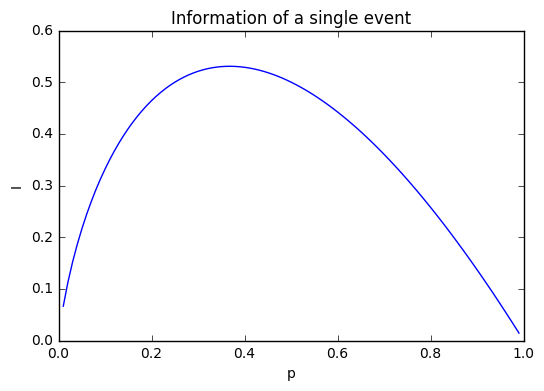

In [9]:
# Calculate the information for different values of p
p = np.arange(0.01,1,0.01)
I = -np.log2(p)

plt.plot(p,I)
plt.xlabel('p')
plt.ylabel('I')
plt.title('Information of a single event')


Entropy measures the average information of a random variable, which in the case of a discrete random variable is defined as:

$$
H = \sum{p_i \log_2p_i}
$$

Where $i$ is a sum over all the possible outcomes of the random variables. This is simply weighing the information of each outcome by the probability of that outcome occuring. The code below calculates the entropy of a Bernoulli variable for different values of p. It shows that the average information is maximum when the probability of that event is $0.5$. When thinking about entropy in terms of unpredictability, it simply shows that an event that occurs with $p = 0.5$ is the most difficult to predict. It also shows that although the unpredictability of a very rare event is very high (and will thus contain a lot of information), the average unpredictability is very low because we could in the case of a Bernoulli variable simply try to predict the event that occurs with probability (1-p).

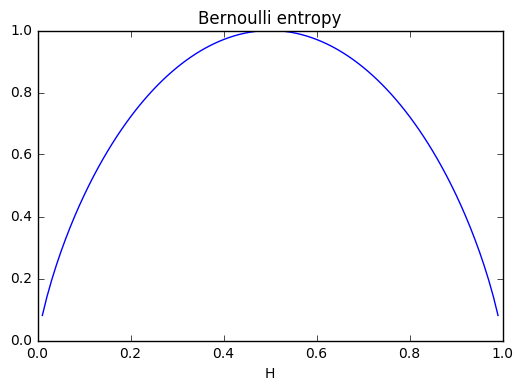

In [8]:
# Calculate the entropy of a Bernoulli distribution for different values of p
p_values = np.arange(0.01,1,0.01)
H_values = []

for p in p_values:
    H = p*np.log2(p) + (1-p)*np.log2(1-p)
    H_values.append(-H)
    
plt.plot(p_values,H_values)
plt.xlabel('p')
plt.xlabel('H')
plt.title('Bernoulli entropy')

## 2. Mutual information

In neural systems we are typically not interested in how predictable a spike in a spike train is. More likely we would want to say how spikes relate to sensory input from the outside world. For this we can use a measure called mutual information, which quantifies how informative one variable is with respect to another variable. It is defined as follows:

$$
I(S;R) = -\sum^R{p(r)\log_2p(r)} - \sum^S{p(s)[-\sum^R{p(r|s)\log_2p(r|s)}]}
$$

The first term on the right hand side is simply the entropy of the response while the second term can be considered a conditional response entropy.

In the following code we calculate the mutual information for a random variable that indicates the probability that a spike will occur in a certain time interval. A stimulus is also presented with some probability. Finally, we calculate the mutual information between spike and stimulus for multiple values for the condition spike distribution. When the condition distribution is approximately 0.5, the mutual information is zero. This simply means that the stimulus is not very informative for predicting the spike. If the probability value in the condition distribution increases, the stimulus becomes a better predictor of the spike and the mutual information increases accordingly



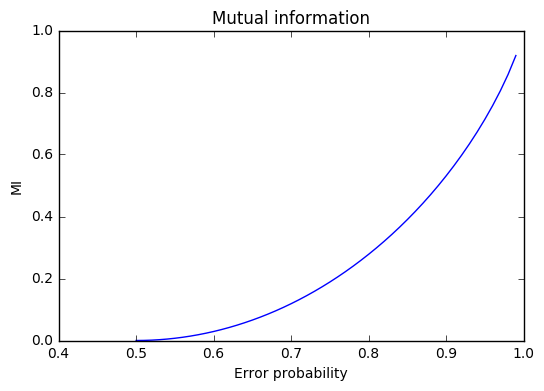

In [12]:
# Mutual information between a spike and a stimulus
p_spike = 0.5 # Probability of a response
p_stim = 0.5 # Probability of a stimulus

H_spike = -(p_spike*np.log2(p_spike) + (1-p_spike)*np.log2(1-p_spike)) # Response/spike entropy

p_cond = np.arange(0.5,1.0,0.01) # Possible values for conditional distribution

MI = np.zeros(len(p_cond))
for i in range(len(p_cond)):
    p = p_cond[i]
    H_spike_stim = -(p*np.log2(p) + (1-p)*np.log2(1-p))
    H_spike_nostim  = -(p*np.log2(p) + (1-p)*np.log2(1-p))
    MI[i] = H_spike - (p_stim*H_spike_stim + (1-p_stim)*H_spike_nostim)

plt.plot(p_cond,MI)
plt.title('Mutual information')
plt.xlabel('Error probability')
plt.ylabel('MI')

## 3 Grandma's recipe for calculating mutual information

Here we apply the method for calculating the mutual information between a stimulus and a neuron. It will be used to find out if, for a Gaussian tuned neuron, there is an optimal value for the standard deviation for that neuron. Here, optimal means that the the mutual information is maximal. We first define three functions: a first one for getting values from a gaussian tuning function and a second one for generating Poisson spike trains for our simulated neuron. The final function calculates the entropy of a frequency distribution of spike counts.

In [16]:
# Gaussian tuning curve
def gauss_tuning(x, x_0,s,r_max=10, r_base= 10):
    return r_base + r_max*np.exp(-0.5*((x-x_0)/s)**2)

# Generates a Poisson spike train
DELTA = 0.001 
def generate_poisson_spiketrain(r_0, T = 1):
    P = r_0*DELTA
    time_points = int(T/DELTA)
    
    spikes = np.random.rand(time_points)
    spikes[spikes < P] = 1
    spikes[spikes < 1] = 0
    return spikes

# Calculate the entropy of a frequency distribution of spike counts
def calculate_entropy(spike_counts):
    H = 0.0
    for s in np.unique(spike_counts):
        p = len(spike_counts[spike_counts == s])/float(len(spike_counts))
        H += -(p*np.log2(p))
    return H

Next we set the parameters for the simulation. We also set the number of different stimulus values that will be presented to the neuron. They are taken uniformly from the range [0, 2*pi*]. Finally we set how many trials are going to be simulated for each stimulus value.

In [14]:
# Parameters for the simulation
pref_stim = np.pi/2   # Prefered input value for the neuron
n_stim    = 10        # range of stimulus values
n_trials  = 50        # Number of stimulus presentations

stim_values = np.linspace(0.0,2*np.pi,n_stim) # Stimulus values that are going to be used in the simulation
sigma_values = np.arange(0.1,8.0,0.2)         # Possible sigma values for the gaussian tuning function
MI = np.zeros(len(sigma_values))              # Stores results for the mutual information

Now we can run our simulation! For each possible value of sigma we will do the following

1. We simulate multiple spike trains for each stimulus value and from these spike trains we can produce a matrix that contains the spike counts for each trial and stimulus value.

2. Using this matrix we can calculate the condition response distribution for each possible stimulus value

3. Using the same matrix we also calculate the total entropy of the responses

4. The quantities calculated in 2 and 3 can now be used to calculate the mutual information

A final plot shows the results. The simulation suggest an optimal value for $\sigma$ can neither be too small or too large. This makes sense as a small value will cause the neuron to fire only for a very small subset of stimulus values and would thus not be very informative for the stimulus set as a whole. Likewise, if $\sigma$ is too large the neuron will respond to most of the stimuli which again is not very informative.

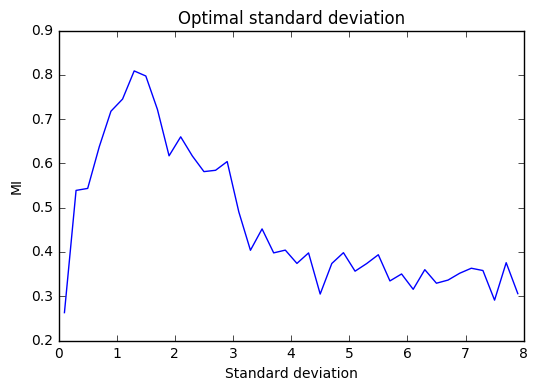

In [18]:
for sigma_idx in range(len(sigma_values)):
    sigma    = sigma_values[sigma_idx]

    # 1. Take a stimulus and present it many times
    spike_counts = np.zeros((n_trials,n_stim))
    for s in range(n_stim):
        for t in range(n_trials):
            r = gauss_tuning(stim_values[s],pref_stim,sigma)
            stim_st = generate_poisson_spiketrain(r)
            spike_counts[t,s] = np.sum(stim_st)    
    
    # 2. Compute the variability due to noise
    NE = 0.0
    for i in range(n_stim):
        HR_S = calculate_entropy(spike_counts[:,i])
        NE += (1.0/n_stim)*HR_S
        
    
    # 3. Compute the total response entropy
    HR = calculate_entropy(spike_counts.flatten())
    
    # 4. Calculate the mutual information
    MI[sigma_idx] = HR - NE
    
# Plotting the results
plt.plot(sigma_values,MI)
plt.title('Optimal standard deviation')
plt.xlabel('Standard deviation')
plt.ylabel('MI')